# Denoising by HQS

We try to solve the following problem with HQS:

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{u-f}||_2^2 + J(\mathbf{u})
$$

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

np.random.seed(0)

In [2]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [3]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 30
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

#img = img/255
#noise_img = noise_img/255

In [4]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 on Gradient

In [5]:
def callback(x, z, xtrue, errx, errz):
    errx.append(np.linalg.norm(x-xtrue))
    errz.append(np.linalg.norm(z-xtrue))

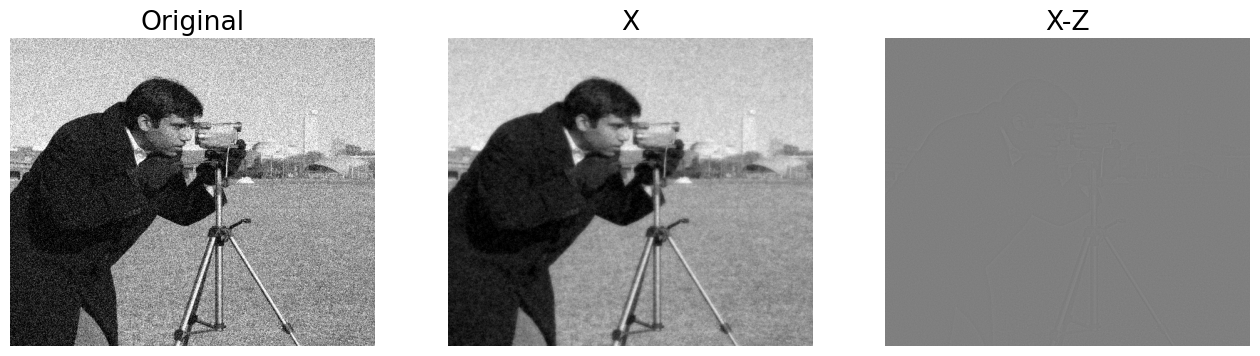

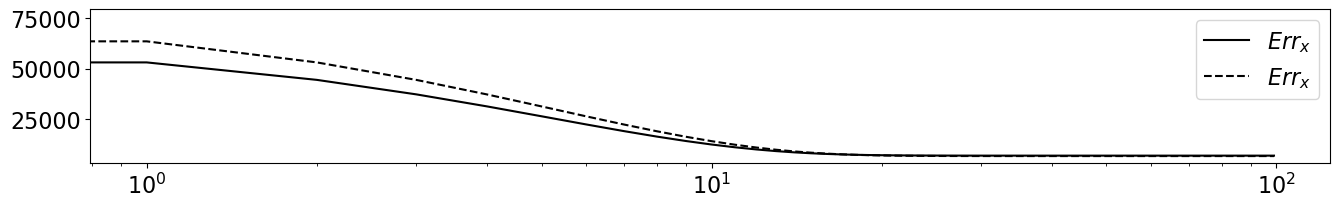

In [6]:
# L2 data term
l2 = L2(b=noise_img.ravel(), niter=5)

# L2 regularization
lamda = 2.
thik = L2(Gop, b=np.zeros(Gop.shape[0]), sigma=lamda, niter=5)

tau = 2e-1
errhqs = []
errhqs1 = []
iml2, iml21 = HQS(l2, thik, tau=tau, x0=np.zeros_like(img.ravel()), niter=100, callbackz=True,
                  callback=lambda xx, zz: callback(xx, zz, img.ravel(), errhqs, errhqs1))
iml2 = iml2.reshape(img.shape)
iml21 = iml21.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml2, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('X')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2-iml21, cmap='gray', vmin=-255, vmax=255)
axs[2].set_title('X-Z')
axs[2].axis('off')
axs[2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.semilogx(errhqs, 'k', label=r'$Err_x$')
ax.semilogx(errhqs1, '--k', label=r'$Err_x$')
ax.legend();

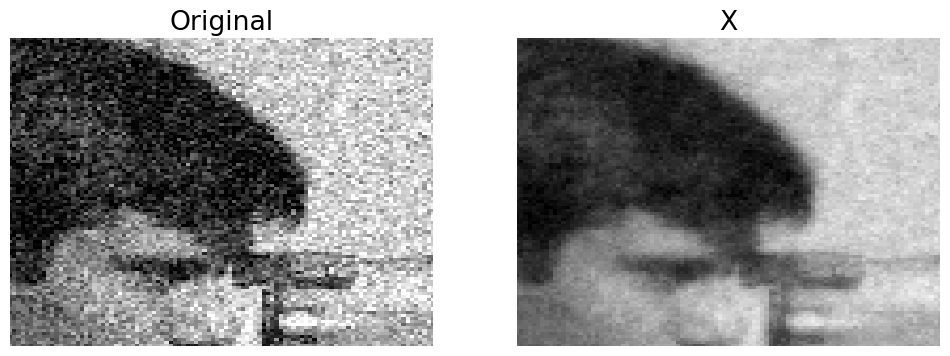

In [7]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
axs[0].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml2, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('X')
axs[1].axis('off')
axs[1].axis('tight')
axs[1].set_xlim(200, 300)
axs[1].set_ylim(170, 70);

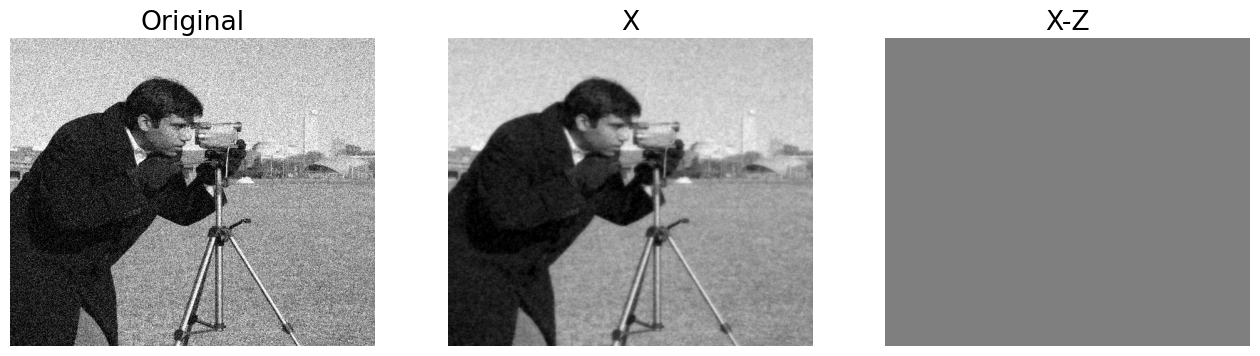

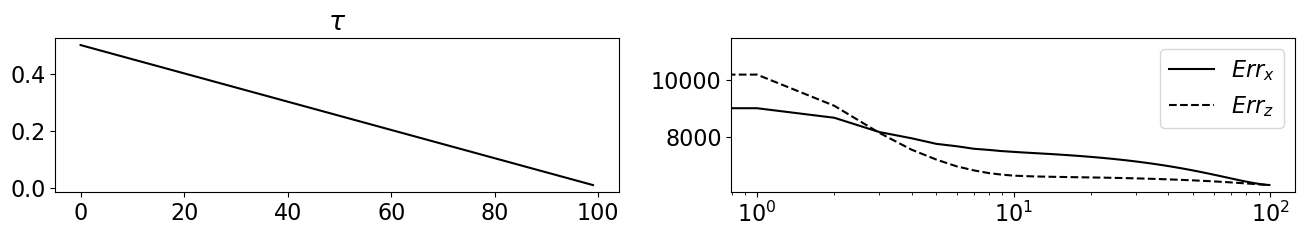

In [8]:
# Variable tau
niter = 100
tau =  np.linspace(5e-1, 1e-2, niter)

errhqs = []
errhqs1 = []
iml2, iml21 = HQS(l2, thik, tau=tau, x0=np.zeros_like(img.ravel()), niter=niter, callbackz=True,
                  callback=lambda xx, zz: callback(xx, zz, img.ravel(), errhqs, errhqs1))
iml2 = iml2.reshape(img.shape)
iml21 = iml21.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml2, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('X')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2-iml21, cmap='gray', vmin=-255, vmax=255)
axs[2].set_title('X-Z')
axs[2].axis('off')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(16, 2))
axs[0].plot(tau, 'k')
axs[0].set_title(r'$\tau$')

axs[1].semilogx(errhqs, 'k', label=r'$Err_x$')
axs[1].semilogx(errhqs1, '--k', label=r'$Err_z$')
axs[1].legend();

## Wavelet L1

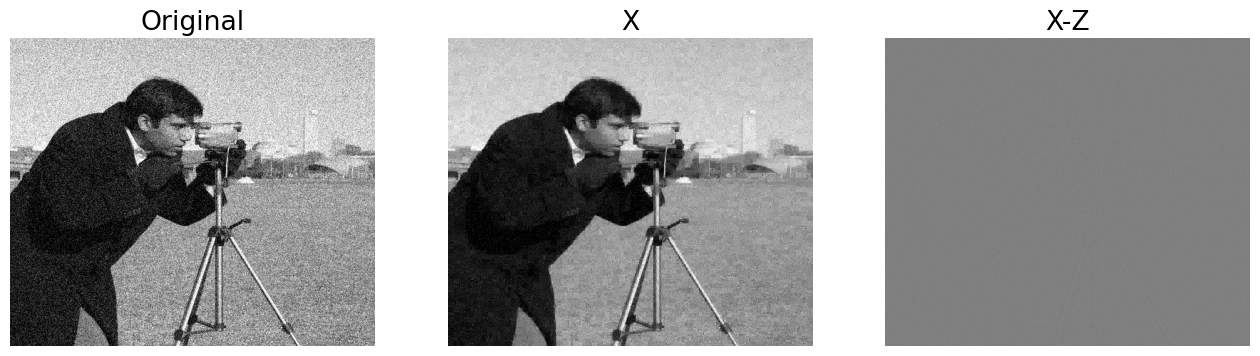

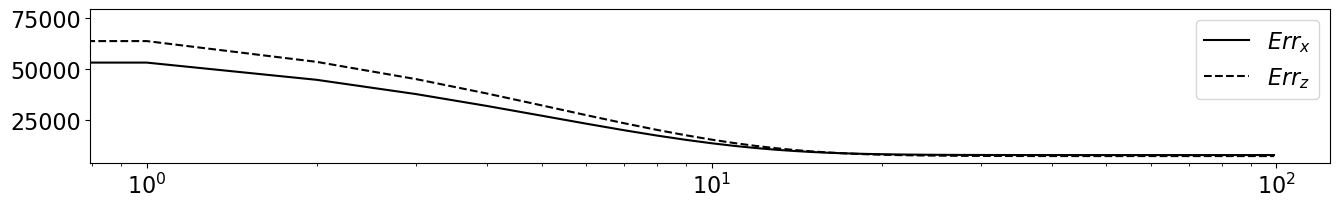

In [9]:
# L1 Wavelet regularization
lamda = 30.
Wop = DWT2D(img.shape, wavelet="haar", level=3)
l1 = Orthogonal(L1(sigma=lamda), Wop)

tau = 2e-1
errhqs = []
errhqs1 = []
iml2, iml21 = HQS(l2, l1, tau=tau, x0=np.zeros_like(img.ravel()), niter=100, callbackz=True,
                  callback=lambda xx, zz: callback(xx, zz, img.ravel(), errhqs, errhqs1))
iml2 = iml2.reshape(img.shape)
iml21 = iml21.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml2, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('X')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2-iml21, cmap='gray', vmin=-255, vmax=255)
axs[2].set_title('X-Z')
axs[2].axis('off')
axs[2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.semilogx(errhqs, 'k', label=r'$Err_x$')
ax.semilogx(errhqs1, '--k', label=r'$Err_z$')
ax.legend();

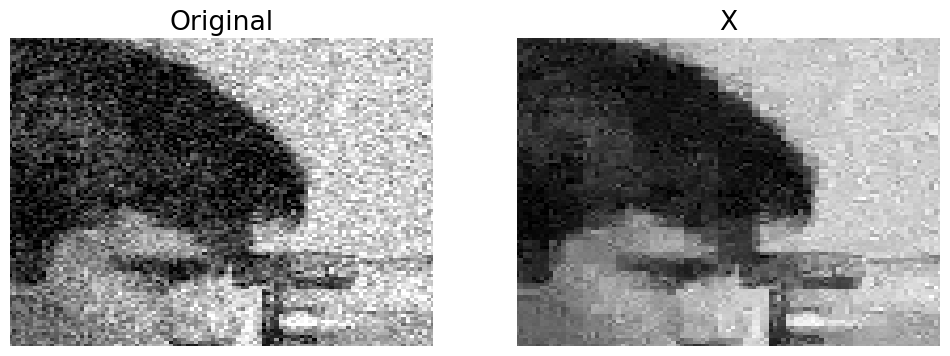

In [10]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
axs[0].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml2, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('X')
axs[1].axis('off')
axs[1].axis('tight')
axs[1].set_xlim(200, 300)
axs[1].set_ylim(170, 70);